# Process GWTC Data

This notebook processes the public data releases from GWTC-1 and GWTC-2 and saves reduced hdf5 posterior sample files into a specified directory. 

File format for h5 files: h5py.File('event_name', key='waveform_model/posterior_samples'). Can also use the key 'waveform_model/priors' to get the priors. 

In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import os
from tqdm import tqdm
from IPython.core.debugger import set_trace

from astropy import cosmology
from astropy.cosmology import z_at_value
import astropy.units as u  
cosmo = cosmology.Planck15

import matplotlib.pyplot as plt

# Put in your path to the samples. File names should be GWXXXXXX_XX.h5. 

GWTC1_path = '/Users/michaelzevin/research/ligo/catalogs/PE/GWTC-1_sample_release/'
GWTC2_path = '/Users/michaelzevin/research/ligo/catalogs/PE/GWTC-2_sample_release/'

output_directory = '/Users/michaelzevin/research/model_selection/model_selection/data/gw_events/'

In [2]:
# conversion function

def m1m2_to_mchirp(m1,m2):
    return (m1*m2)**(3./5) / (m1+m2)**(1./5)

def m1m2_to_mtot(m1,m2):
    return m1+m2

def m1m2_to_q(m1,m2):
    # q is defined as m2/m1 with m2<=m1
    q = m2/m1
    pos_idxs = np.argwhere(q > 1)
    q[pos_idxs] = m1[pos_idxs]/m2[pos_idxs]
    return q

def m1m2_to_eta(m1,m2):
    eta = (m1*m2) / (m1+m2)**2
    return eta

def components_to_chieff(m1,m2,a1,a2,costilt1,costilt2):
    return (m1*a1*costilt1 + m2*a2*costilt2) / (m1+m2)

# create interpolant for determining redshifts from luminosity distances
dL_max = 20000 # Mpc
dL_vals = np.linspace(0.0001, dL_max, 10000)
redshift_vals = np.asarray([z_at_value(cosmo.luminosity_distance, dL*u.Mpc) for dL in dL_vals])
z_from_dL = interp1d(dL_vals, redshift_vals)

def dL_to_redshift(dL):
    # Input distance in Mpc
    # Use interpolant above to speed this up
    return z_from_dL(dL)


params we are currently saving: ['m1', 'm2', 'mchirp', 'mtot', 'q', 'eta', 'chieff', 'dL', 'z']

### GWTC-1 Events

In [3]:
for gw_file in tqdm(os.listdir(GWTC1_path)):
    gw_name = gw_file.split('.')[0]
    
    # remove BNS event
    if gw_name == 'GW170817':
        continue
        
    for oldkey, newkey in zip(['IMRPhenomPv2_posterior', 'Overall_posterior', 'SEOBNRv3_posterior', 'prior'], ['IMRPhenomPv2', 'combined', 'SEOBNRv3', 'prior']):
        df = pd.read_hdf(os.path.join(GWTC1_path,gw_file), key=oldkey)
        
        # luminosity distance and redshift
        dL = np.asarray(df['luminosity_distance_Mpc'])
        z = np.asarray(dL_to_redshift(df['luminosity_distance_Mpc']))
        
        # chirp mass and total mass (source frame)
        m1_src = np.asarray(df['m1_detector_frame_Msun']/(1+z))
        m2_src = np.asarray(df['m2_detector_frame_Msun']/(1+z))
        mchirp = m1m2_to_mchirp(m1_src, m2_src)
        mtot = m1m2_to_mtot(m1_src, m2_src)
        
        # q and eta
        q = m1m2_to_q(m1_src, m2_src)
        eta = m1m2_to_eta(m1_src, m2_src)
        
        # chieff
        chieff = components_to_chieff(m1_src, m2_src, np.asarray(df['spin1']), np.asarray(df['spin2']), \
                                      np.asarray(df['costilt1']), np.asarray(df['costilt2']))
        
        # save everything in new dataframe
        new_df = pd.DataFrame({'m1':m1_src, 'm2':m2_src, 'mchirp':mchirp, 'mtot':mtot, 'q':q, 'eta':eta, 'chieff':chieff, 'dL':dL, 'z':z})
        new_df.to_hdf(os.path.join(output_directory,gw_name+'.hdf5'), key=newkey)
        

100%|██████████| 11/11 [00:01<00:00,  6.85it/s]


### GWTC-2 Events

In [26]:
for gw in os.listdir(GWTC2_path):
    print(gw)
    for key in f.keys():
        try:
            print('  '+key)
            df = pd.read_hdf(os.path.join(GWTC2_path, gw), key=key+'/posterior_samples')
            print('    {}'.format(np.median(df['mass_ratio'])))
        except:
            continue

S190421ar.h5
  C01:IMRPhenomD
    0.7850659325280822
  C01:IMRPhenomPv2
    0.7287335199864725
  C01:NRSur7dq4
    0.793584100345
  C01:SEOBNRv4P
    0.7404475899902062
  C01:SEOBNRv4P_nonevol
    0.7404389570832479
  PrecessingSpinIMR
    0.7341981895078202
  PrecessingSpinIMRHM
    0.792492456353
  PublicationSamples
    0.792524623211
  ZeroSpinIMR
    0.7839031657741296
  history
  version
GW190517_055101_comoving.h5
  C01:IMRPhenomD
    0.385305868062988
  C01:IMRPhenomPv2
    0.6710867243596361
  C01:NRSur7dq4
    0.675881067634
  C01:SEOBNRv4P
    0.616477114864419
  C01:SEOBNRv4P_nonevol
    0.6126438781023593
  PrecessingSpinIMR
    0.6410631096374896
  PrecessingSpinIMRHM
    0.690126328832
  PublicationSamples
    0.6897003232404999
  ZeroSpinIMR
    0.38503118892795585
  history
  version
GW190620_030421_prior.npy
  C01:IMRPhenomD
  C01:IMRPhenomPv2
  C01:NRSur7dq4
  C01:SEOBNRv4P
  C01:SEOBNRv4P_nonevol
  PrecessingSpinIMR
  PrecessingSpinIMRHM
  PublicationSamples
  ZeroS

In [4]:
for gw_file in tqdm(os.listdir(GWTC2_path)):
    
    # remove marginal events
    if gw_file[:2] != 'GW':
        continue
        
    # remove the comoving distance posteriors and prior files
    if 'comoving' in gw_file or 'prior' in gw_file:
        continue
        
    gw_name = gw_file.split('.')[0]
        
    # remove BNS/NSBH events
    if any([x in gw_name for x in ['GW190425','GW190426','GW190814']]):
        continue
        
        
    for oldkey, newkey in zip(['C01:IMRPhenomD', 'C01:IMRPhenomPv2', 'C01:SEOBNRv4P', 'PublicationSamples'], \
                              ['IMRPhenomD', 'IMRPhenomPv2', 'SEOBNRv4P', 'combined']):
        try:
            f = h5py.File(os.path.join(GWTC2_path, gw_file))
            data = f.get(oldkey+'/posterior_samples')
            df = pd.DataFrame(np.asarray(data))
            
            # luminosity distance and redshift
            dL = np.asarray(df['luminosity_distance'])
            z = np.asarray(df['redshift'])

            # chirp mass and total mass (source frame)
            m1_src = np.asarray(df['mass_1_source'])
            m2_src = np.asarray(df['mass_2_source'])
            mchirp = np.asarray(df['chirp_mass_source'])
            mtot = np.asarray(df['total_mass_source'])

            # q and eta
            q = np.asarray(df['mass_ratio'])
            eta = np.asarray(df['symmetric_mass_ratio'])

            # chieff
            chieff = components_to_chieff(m1_src, m2_src, np.asarray(df['a_1']), np.asarray(df['a_2']), \
                                          np.asarray(df['cos_tilt_1']), np.asarray(df['cos_tilt_2']))

            # save everything in new dataframe
            new_df = pd.DataFrame({'m1':m1_src, 'm2':m2_src, 'mchirp':mchirp, 'mtot':mtot, 'q':q, 'eta':eta, 'chieff':chieff, 'dL':dL, 'z':z})
            new_df.to_hdf(os.path.join(output_directory,gw_name+'.hdf5'), key=newkey)
            
        except:
            # exception since some of the events don't have certain approximants
            print('{} does not have the following approximant: {}'.format(gw_name, newkey))
        
        
    

 85%|████████▌ | 165/194 [00:45<00:17,  1.69it/s]

GW190521 does not have the following approximant: IMRPhenomD
GW190521 does not have the following approximant: IMRPhenomPv2
GW190521 does not have the following approximant: SEOBNRv4P


100%|██████████| 194/194 [00:49<00:00,  3.93it/s]


## Construct prior distribution

In [7]:
cosmo.luminosity_distance(2).value

15934.616365744776

In [28]:
def draw_from_prior(N, Mmax=150, dLmax=cosmo.luminosity_distance(2).value):
    dL = dLmax * np.random.power(3, size=N)
    m1_det = np.random.uniform(low=5, high=Mmax, size=N)
    m2_det = np.random.uniform(low=5, high=Mmax, size=N)
    mc_det = m1m2_to_mchirp(m1_det,m2_det)
    a1 = np.random.uniform(low=0, high=1, size=N)
    a2 = np.random.uniform(low=0, high=1, size=N)
    costilt1 = np.random.uniform(low=-1, high=1, size=N)
    costilt2 = np.random.uniform(low=-1, high=1, size=N)
    
    # get redshifts from luminosity distances
    z = dL_to_redshift(dL)
    
    # get source-frame masses and chirp mass
    m1_src = m1_det / (1+z)
    m2_src = m2_det / (1+z)
    mc_src = m1m2_to_mchirp(m1_src,m2_src)
    
    # get q and chieff
    q = m1m2_to_q(m1_src, m2_src)
    chieff = components_to_chieff(m1_src,m2_src,a1,a2,costilt1,costilt2)
    
    prior = pd.DataFrame(np.asarray([mc_src, q, chieff, z]).T, columns=['mchirp', 'q', 'chieff', 'z'])
    
    return prior

In [29]:
df = draw_from_prior(100000)

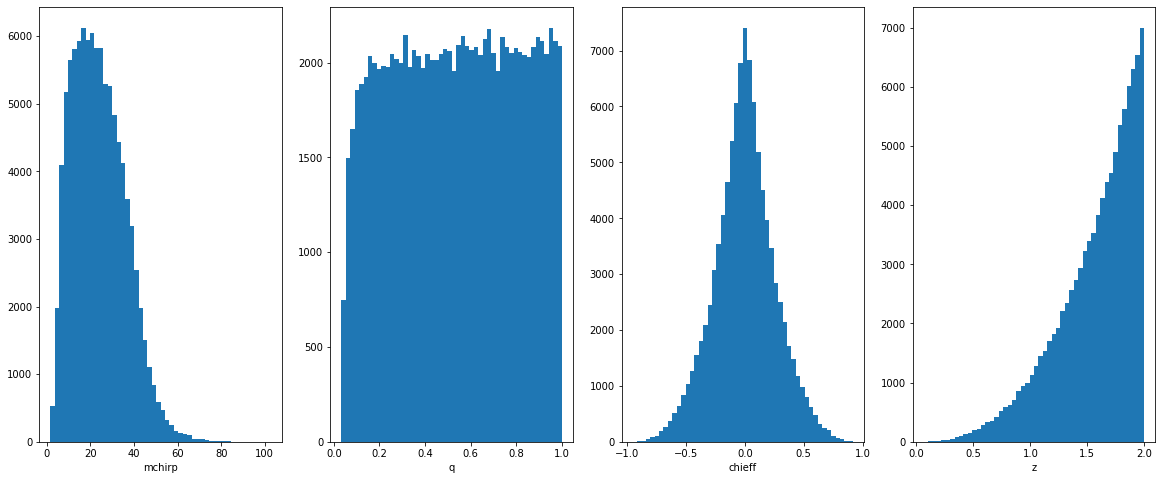

In [30]:
fig, axs = plt.subplots(1,4, figsize=(20,8))
for param, ax in zip(['mchirp','q','chieff','z'], axs):
    _ = ax.hist(df[param], bins=50)
    ax.set_xlabel(param)

In [31]:
df.to_hdf(os.path.join(output_directory, 'LVC_prior.hdf5'), key='samples')